In [221]:
import pysam
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import ceil

In [222]:
fetch_df = pd.read_csv('interesting_genes.bed', sep='\t', header=None, names=['chr', 'start', 'stop', 'gene'])

In [223]:
#pysam.index("../WES-normal.bam")

In [224]:
border_shift = 100000

In [225]:
samfile = pysam.AlignmentFile('../WES-normal.bam', 'rb')
genes_bam = pysam.AlignmentFile('../genes.bam', 'wb', template=samfile)

d = []

for index, gene in fetch_df.iterrows():
    start = gene['start'] - border_shift
    stop = gene['stop'] + border_shift
    if start < 0:
        start = 0
    for read in samfile.fetch(gene['chr'], start, stop):
        genes_bam.write(read)
    for pileupcolumn in samfile.pileup(gene['chr'], start, stop):
        d.append(
                {
                    'position': pileupcolumn.pos,
                    'read_count': pileupcolumn.n,
                    'chromosome': gene['chr'],
                    'gene': gene['gene']
                }
            )

df_normal = pd.DataFrame(d)

genes_bam.close()
samfile.close()

In [226]:
#pysam.index("../WES-tumor.bam")

In [227]:
samfile = pysam.AlignmentFile('../WES-tumor.bam', 'rb')
genes_bam = pysam.AlignmentFile('../genes_tumor.bam', 'wb', template=samfile)

d = []

for index, gene in fetch_df.iterrows():
    start = gene['start'] - border_shift
    stop = gene['stop'] + border_shift
    if start < 0:
        start = 0
    for read in samfile.fetch(gene['chr'], start, stop):
        genes_bam.write(read)
    
    for pileupcolumn in samfile.pileup(gene['chr'], start, stop):
            d.append(
                {
                    'position': pileupcolumn.pos,
                    'read_count': pileupcolumn.n,
                    'chromosome': gene['chr'],
                    'gene': gene['gene']
                }
            )

df_tumor = pd.DataFrame(d)

genes_bam.close()
samfile.close()

In [228]:
df_tumor.drop_duplicates(subset=['position'], inplace = True)
df_normal.drop_duplicates(subset=['position'], inplace = True)

In [229]:
df_total = df_tumor.merge(df_normal, left_on='position', right_on='position',
          suffixes=('_tumor', '_normal'), how='outer')

In [230]:
df_total['depth_ratio'] = np.log2(df_total['read_count_tumor'] / df_total['read_count_normal'])

In [231]:
df_total['median_rolling_depth_ratio'] = df_total['depth_ratio'].rolling(10000, min_periods=1, center=True).median(skipna=False) 

In [232]:
bin_size = 5000
bins = np.concatenate([([i]*bin_size) for i in range(ceil(df_total.shape[0] / bin_size))], axis=0)[:df_total.shape[0]]
df_total['bin'] = bins

In [233]:
df_group = df_total[['position', 'depth_ratio', 'bin']].groupby(['bin'])['depth_ratio'].median()
df_group = df_group.reset_index() 
median_binning_depth_ratio = np.concatenate([([i]*bin_size) for i in df_group['depth_ratio']], axis=0)[:df_total.shape[0]]
df_total['median_binning_depth_ratio'] = median_binning_depth_ratio

In [236]:
bin_size = 5000
bins = np.concatenate([([i]*bin_size) for i in range(ceil(df_total.shape[0] / bin_size))], axis=0)[:df_total.shape[0]]
df_total['bin'] = bins

df_group = df_total[['position', 'median_rolling_depth_ratio', 'bin']].groupby(['bin'])['median_rolling_depth_ratio'].median()
df_group = df_group.reset_index() 
median_rolling_binning_depth_ratio = np.concatenate([([i]*bin_size) for i in df_group['median_rolling_depth_ratio']], axis=0)[:df_total.shape[0]]
df_total['median_rolling_binning_depth_ratio'] = median_rolling_binning_depth_ratio

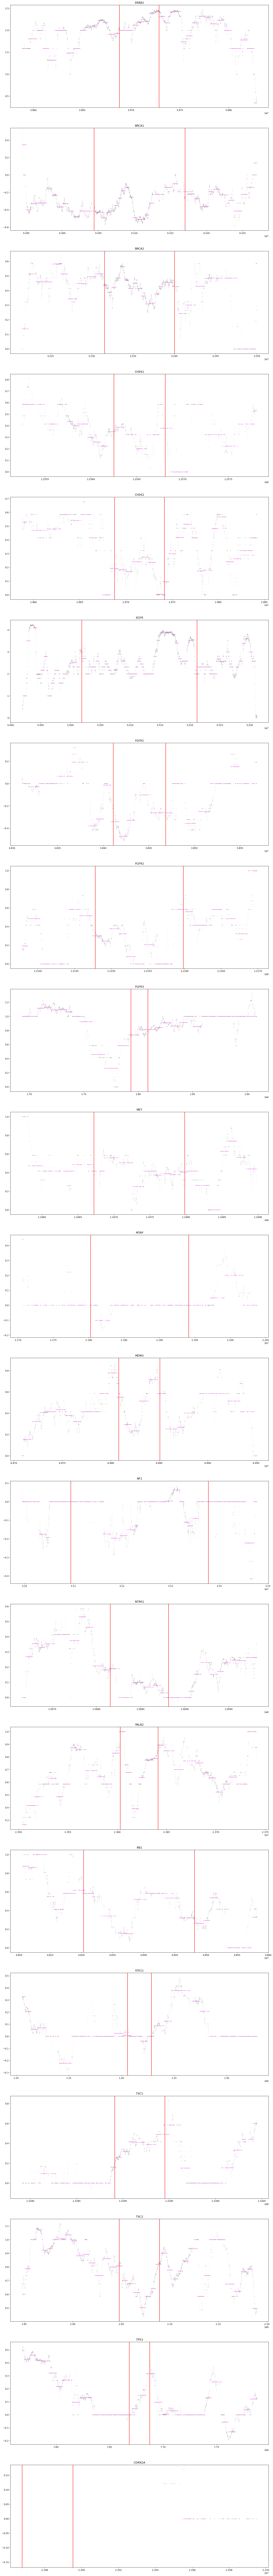

In [237]:
fig, axs = plt.subplots(len(fetch_df['gene']))
fig.set_size_inches(20, 200)

for i, gene in enumerate(fetch_df['gene']):
    target_gene = gene
    #axs[i].scatter(df_total[df_total['gene_tumor'] == target_gene]['position'], df_total[df_total['gene_tumor'] == target_gene]['median_binning_depth_ratio'], alpha=0.5, s=0.001)
    axs[i].scatter(df_total[df_total['gene_tumor'] == target_gene]['position'], df_total[df_total['gene_tumor'] == target_gene]['median_rolling_depth_ratio'], alpha=0.1, s=0.001, c='grey')
    axs[i].scatter(df_total[df_total['gene_tumor'] == target_gene]['position'], df_total[df_total['gene_tumor'] == target_gene]['median_rolling_binning_depth_ratio'], alpha=0.5, s=0.001, c='violet')

    #axs[i].scatter(df_total[df_total['Gene_tumor'] == target_gene]['Position'], df_total[df_total['Gene_tumor'] == target_gene]['depth_ratio'], alpha=0.05, s=0.001, c='red')
    axs[i].axvline(x = fetch_df[fetch_df['gene'] == target_gene]['start'].iloc[0], color = 'r')
    axs[i].axvline(x = fetch_df[fetch_df['gene'] == target_gene]['stop'].iloc[0], color = 'r')
    axs[i].set_title(gene)

In [210]:
#df_total[df_total['Gene_tumor'] == target_gene].iloc[100:160]